# May 21,24,25, 2022: pytorch implementation of model: idea1

In [1]:
import os
import sys
from os.path import join as pjoin

import numpy as np
import pandas as pd
import scipy as sp

import torch
import torch.nn as nn 
print(torch.cuda.is_available())

import pickle, time, random
# import neural_structured_learning as nsl
from tqdm import tqdm
import json
from itertools import combinations, product
from operator import add
import copy

# explanation tools
import captum

# plotting
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import hypernetx as hnx
from networkx import fruchterman_reingold_layout as layout

# nilearn
from nilearn import image
from nilearn import masking
from nilearn import plotting

# main dirs
proj_dir = pjoin(os.environ['HOME'], 'explainable-ai')
results_dir = f"{proj_dir}/results"
month_dir = f"{proj_dir}/nb/may22"

# folders
sys.path.insert(0, proj_dir)
import helpers.pytorch.dataset_utils as dataset_utils
import helpers.pytorch.model_definitions as model_definitions
import data.emoprox2.scripts.stimulus_utils as stimulus_utils

True


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## data

In [3]:
def get_data(data, subject_list):
    X = [] 
    y = []
    global MASK

    for subject in subject_list:
        X += [torch.FloatTensor(x) for x in data[subject]['X']]
        y += [torch.LongTensor(y) for y in (data[subject]['y'])]

    X = nn.utils.rnn.pad_sequence(X, batch_first=True, padding_value=MASK)
    y = nn.utils.rnn.pad_sequence(y, batch_first=True, padding_value=MASK)

    X_len = torch.LongTensor([len(seq) for seq in X])
    return X.to(device), y.to(device), X_len.to('cpu')
    # return X, y, X_len

In [4]:
'''
target stimuli
'''
APPR, RETR = 1, 0
MASK = -100

data_file = f"{proj_dir}/data/emoprox2/idea1_data.pkl"
with open(data_file, 'rb') as f:
    data = pickle.load(f)

'''
(hyper)-parameters
'''
class ARGS(): pass
args = ARGS()

args.SEED = 74

# data args
args.num_subjects = len(data.keys())
args.num_train = round(0.45 * args.num_subjects)
args.num_valid = round(0.05 * args.num_subjects)
args.num_test = round(0.5 * args.num_subjects)

# model args
args.num_units = 32 #16 #32
args.num_classes = 2 # for binary classification
args.l2 = 1e-2
args.dropout = 0.5
args.learning_rate = 4e-4

args.num_epochs = 50
args.validation_split = 0.2
args.batch_size = 64

args.return_sequences = True

'''
generate dataset for the model
'''
subject_list = list(data.keys())
random.Random(args.SEED).shuffle(subject_list)

train_list = subject_list[:args.num_train]
valid_list = subject_list[args.num_train : args.num_train + args.num_valid]
test_list = subject_list[args.num_train + args.num_valid:]

(X_train, y_train, 
 len_train) = get_data(data, train_list)
(X_valid, y_valid, 
 len_valid) = get_data(data, valid_list)
(X_test, y_test, 
 len_test) = get_data(data, test_list)

print(X_train.shape, X_valid.shape, X_test.shape)

args.input_size = X_train.shape[-1]

torch.Size([9124, 8, 85]) torch.Size([1030, 8, 85]) torch.Size([10254, 8, 85])


## model and training

In [5]:
class GRU_classifier(nn.Module):
    def __init__(self, args):
        super(GRU_classifier, self).__init__()
        self.gru = nn.GRU(
            input_size=args.input_size,
            hidden_size=args.num_units,
            num_layers=1,
            batch_first=True,
            dropout=args.dropout
        )
        self.fc = nn.Linear(args.num_units, args.num_classes)

    def forward(self, x):
        x, _ = self.gru(x)
        y = self.fc(x)
        return y

In [6]:
def accfn(y_true, y_pred):
    labels_pred = torch.argmax(y_pred, axis=-1)
    mask = (y_true != MASK).bool()
    correct = 1-torch.abs(labels_pred[mask] - y_true[mask])
    return correct.sum() / len(correct)

In [7]:
def train(model, X, y, opt, lossfn, permutation):
    epoch_losses = []
    epoch_accs = []

    model.train()

    for i in range(0, X.size()[0], args.batch_size):
        indices = permutation[i:i + args.batch_size]
        batch_x, batch_y = X[indices], y[indices]

        y_pred = model(batch_x,)
        loss = lossfn(
            y_pred.view(-1, args.num_classes), 
            batch_y.view(-1)
        )

        acc = accfn(batch_y, y_pred)

        opt.zero_grad()
        loss.backward()
        opt.step()

        epoch_losses += [loss.item()]
        epoch_accs += [acc.item()]

    return  np.sum(epoch_losses) / len(epoch_losses), np.sum(epoch_accs) / len(epoch_accs)


def evaluate(model, X, y, lossfn, permutation):
    epoch_losses = []
    epoch_accs = []

    model.eval()

    with torch.no_grad():
        for i in range(0, X.size()[0], args.batch_size):
            indices = permutation[i:i + args.batch_size]
            batch_x, batch_y = X[indices], y[indices]

            y_pred = model(batch_x,)
            loss = lossfn(
                y_pred.view(-1, args.num_classes), 
                batch_y.view(-1)
            )

            acc = accfn(batch_y, y_pred)

            epoch_losses += [loss.item()]
            epoch_accs += [acc.item()]
    
    return np.sum(epoch_losses) / len(epoch_losses), np.sum(epoch_accs) / len(epoch_accs)

In [8]:
model_file = f"{results_dir}/emoprox_full_data/models/GRU_classifier_gruunits_{args.num_units}_idea1.pt"
history_file = f"{results_dir}/emoprox_full_data/models/GRU_classifier_gruunits_{args.num_units}_idea1_history"

model = GRU_classifier(args)
lossfn = nn.CrossEntropyLoss(ignore_index=MASK, reduction='mean')
opt = torch.optim.Adam(model.parameters())

model.to(device)
lossfn.to(device)

if os.path.exists(model_file):

    model.load_state_dict(torch.load(model_file))
    with open(history_file, 'rb') as f:
        history = pickle.load(f)

else:
    
    permut_train = torch.randperm(X_train.size()[0])
    permut_valid = torch.randperm(X_valid.size()[0])

    best_valid_loss = float('inf')

    train_loss, train_acc = np.zeros(args.num_epochs), np.zeros(args.num_epochs)
    valid_loss, valid_acc = np.zeros(args.num_epochs), np.zeros(args.num_epochs)

    for epoch in range(args.num_epochs):
        train_loss[epoch], train_acc[epoch] = train(model, X_train, y_train, opt, lossfn, permut_train)
        valid_loss[epoch], valid_acc[epoch] = evaluate(model, X_valid, y_valid, lossfn, permut_valid)

        if valid_loss[epoch] < best_valid_loss:
            best_valid_loss = valid_loss[epoch]
            torch.save(model.state_dict(), model_file)
        
        print(f'Epoch: {epoch+1:02}')
        print(f'\tTrain Loss: {train_loss[epoch]:.3f} | Train Acc: {train_acc[epoch]*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss[epoch]:.3f} |  Val. Acc: {valid_acc[epoch]*100:.2f}%')

    history = {
        'train_loss': train_loss,
        'train_acc': train_acc,
        'valid_loss': valid_loss,
        'valid_acc': valid_acc
    }

    torch.save(model.state_dict(), model_file)
    with open(history_file, 'wb') as f:
        pickle.dump(history, f)


/home/govindas/venvs/expln-ai3.9/lib/python3.9/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


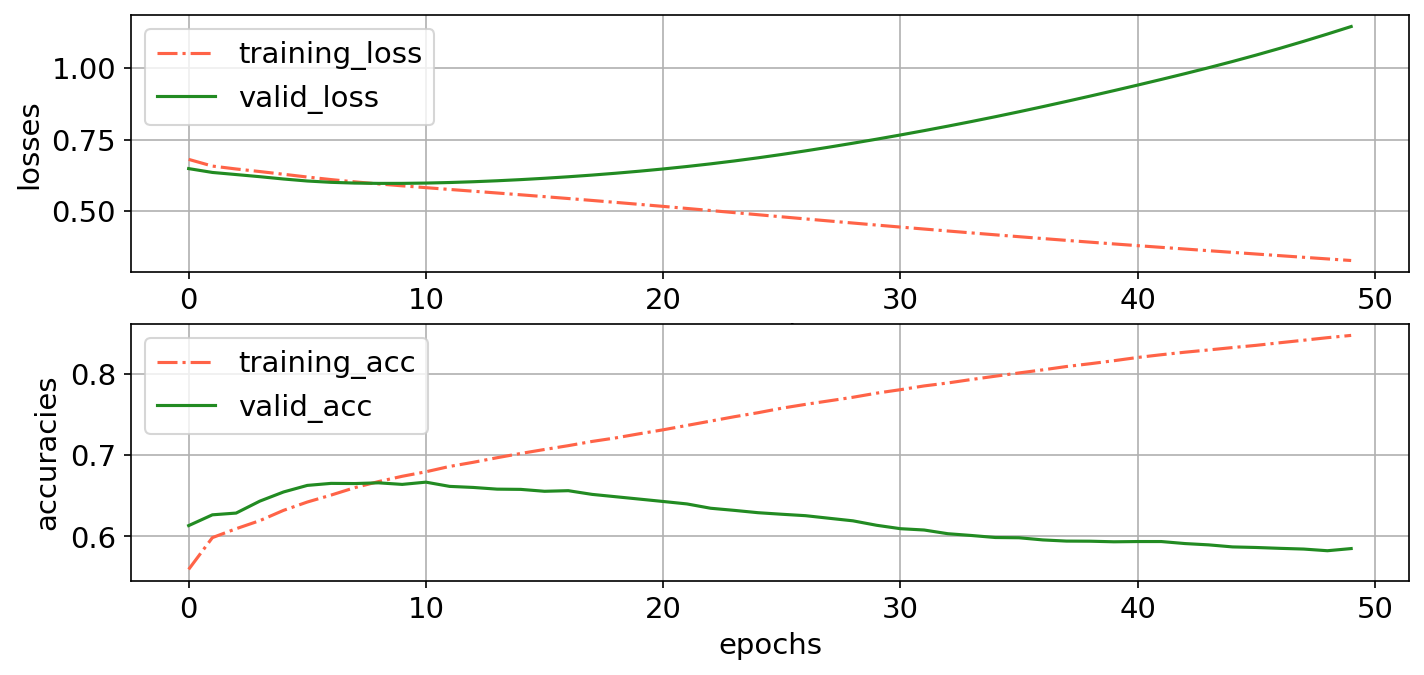

In [9]:
fig, axs = plt.subplots(
    nrows=2, ncols=1,
    figsize=(11,5),
    dpi=150
)

ax = axs[0]
ax.plot(history['train_loss'], color='tomato', linestyle='-.', label='training_loss')
ax.plot(history['valid_loss'], color='forestgreen', label='valid_loss')
ax.set_ylabel(f"losses")
ax.set_xlabel(f"epochs")
ax.legend()
ax.grid(True)

ax = axs[1]
ax.plot(history['train_acc'], color='tomato', linestyle='-.', label='training_acc')
ax.plot(history['valid_acc'], color='forestgreen', label='valid_acc')
ax.set_ylabel(f"accuracies")
ax.set_xlabel(f"epochs")
ax.legend()
ax.grid(True)

`Overfittting` the training data.

## interpretation(s)

In [11]:
def plot_roi_vec_on_niimg(roi_data, mask):
    # create an empty stat img
    stat_img_all_rois = image.new_img_like(ref_niimg=mask, 
                                           data=np.zeros_like(mask.get_fdata()[..., None], 
                                                              dtype=np.float32), 
                                           copy_header=True)
    
    # unmask roi value on all voxels of the roi
    for idx_roi in tqdm(np.arange(roi_data.shape[-1])):
        mask_roi = image.math_img(f"img=={idx_roi+1}", img=mask)
        num_voxels = np.where(mask_roi.get_fdata())[0].shape[0]
        vox_data = roi_data[:, idx_roi][:, None] @ np.ones(shape=(num_voxels,))[None, :] # time x voxels
        stat_img = masking.unmask(vox_data, mask_img=mask_roi)
        stat_img_all_rois = image.math_img(f"img_all+img_roi", 
                                           img_all=stat_img_all_rois, 
                                           img_roi=stat_img)
        
    return stat_img_all_rois

parcellation_file = f"/home/govindas/parcellations/templates/MAX_ROIs_final_gm_85.nii.gz"
# print(mask_file)
parcellation = image.load_img(parcellation_file)

In [12]:
def forward_func(X):
    y_ = nn.functional.softmax(model(X))
    return y_.view(-1, args.num_classes)

class softmax_model(nn.Module):
    def __init__(self, model):
        super(softmax_model, self).__init__()
        self.model = model
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, x):
        x = self.model(x)
        return self.softmax(x).view(-1, args.num_classes)

sf_model = softmax_model(model)
sf_model.to(device)

softmax_model(
  (model): GRU_classifier(
    (gru): GRU(85, 32, batch_first=True, dropout=0.5)
    (fc): Linear(in_features=32, out_features=2, bias=True)
  )
  (softmax): Softmax(dim=-1)
)

In [13]:
from captum.attr import Saliency

def saliency_attributes(target_class):
    names = ['train', 'test']
    inputs, targets = [], []
    for (X, y) in zip([X_train, X_test], [y_train, y_test]):
        idxs = y[:, 0] == target_class
        inputs.append(X[idxs, ...])
        targets.append(y[idxs, ...])
    
    saliency = Saliency(sf_model)
    attributions = {}
    for name, input, target in zip(names, inputs, targets):
        model.train()
        model.zero_grad()

        attribs = saliency.attribute(
            input,
            target=target_class,
            abs=False,
        )

        attribs = torch.mul(attribs, (target != MASK)[:, :, None]).cpu().numpy()
        attribs = np.ma.masked_where(attribs == 0.0, attribs)
        attributions[name] = attribs
        
    return attributions

In [14]:
attributions = {}
for target_class in [APPR, RETR]:
    attributions[target_class] = saliency_attributes(target_class)

/home/govindas/venvs/expln-ai3.9/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


In [23]:
attributions[APPR]['train'].shape

torch.Size([9124, 8, 85])


(4091, 8, 85)

In [ ]:
'''
null saliency distribution
'''
method = 'saliency'
num_null = 100
for name in ['train', 'test']:
    true_mean, null_mean, null_std = {}, {}, {}

    true_appr, true_retr = attributions[APPR][name], attributions[RETR][name]
    num_appr, num_retr = true_appr.shape[0], true_retr.shape[0]

    null_appr, null_retr = [], []
    for idx_null in tqdm(np.arange(num_null)):
        n_concat = np.ma.concatenate((true_appr.copy(), true_retr.copy()), axis=0)
        np.random.shuffle(n_concat)
        n_a, n_r = n_concat[:num_appr, ...], n_concat[num_appr:, ...]
        null_appr.append(n_a)
        null_retr.append(n_r)

    null_appr = np.ma.stack(null_appr, axis=-1)
    null_retr = np.ma.stack(null_retr, axis=-1)

    null_appr_means = np.ma.mean(null_appr, axis=0)
    null_retr_means = np.ma.mean(null_retr, axis=0)

    null_mean[APPR] = np.ma.mean(null_appr_means, axis=-1) 
    null_std[APPR] = np.ma.std(null_appr_means, axis=-1) #/np.sqrt(null_appr_means.shape[-1])
    null_mean[RETR] = np.ma.mean(null_retr_means, axis=-1) 
    null_std[RETR] = np.ma.std(null_retr_means, axis=-1) #/np.sqrt(null_retr_means.shape[-1])

    true_mean[APPR] = np.ma.mean(true_appr, axis=0)
    true_mean[RETR] = np.ma.mean(true_retr, axis=0)

    for target_class in [APPR, RETR]:
        cond_nifti_file = (
            f"{results_dir}/emoprox_full_data/interpretations" 
            f"/idea1_method-{method}_name-{name}_target_class-{target_class}_true_ts.nii.gz"
        )
        if not os.path.exists(cond_nifti_file):
            stat_img_all_rois = plot_roi_vec_on_niimg(
                roi_data=true_mean[target_class],
                mask=parcellation
            )
            stat_img_all_rois.to_filename(cond_nifti_file)

        null_nifti_file = (
            f"{results_dir}/emoprox_full_data/interpretations"
            f"/idea1_method-{method}_name-{name}_target_class-{target_class}_null_lower_ts.nii.gz"
        )
        if not os.path.exists(null_nifti_file):
            stat_img_all_rois = plot_roi_vec_on_niimg(
                roi_data=null_mean[target_class]-null_std[target_class],
                mask=parcellation
            )
            stat_img_all_rois.to_filename(null_nifti_file)

        null_nifti_file = (
            f"{results_dir}/emoprox_full_data/interpretations"
            f"/idea1_method-{method}_name-{name}_target_class-{target_class}_null_upper_ts.nii.gz"
        )
        if not os.path.exists(null_nifti_file):
            stat_img_all_rois = plot_roi_vec_on_niimg(
                roi_data=null_mean[target_class]+null_std[target_class],
                mask=parcellation
            )
            stat_img_all_rois.to_filename(null_nifti_file)

100%|██████████| 100/100 [00:18<00:00,  5.46it/s]


In [ ]:
# from captum.attr import IntegratedGradients

# method = 'IG'
# ig = IntegratedGradients(sf_model, multiply_by_inputs=True)

# for name, input, target in zip(names, inputs, targets):
#     model.train()
#     model.zero_grad()
    
#     cond_nifti_file = (f"{results_dir}/emoprox_full_data/interpretations" 
#                        f"/idea1_method-{method}_name-{name}_target_class-{target_class}_ts.nii.gz")
#     if not os.path.exists(cond_nifti_file):

#         baselines = 0.0
#         attribs = ig.attribute(
#             input, 
#             baselines,
#             target=target_class,
#             n_steps=500,
#             internal_batch_size=input.shape[0],
#             return_convergence_delta=False
#         )

#         attribs = torch.mul(attribs, (target != MASK)[:, :, None]).cpu().numpy()
#         attribs = np.ma.masked_where(attribs == 0.0, attribs)

#         stat_img_all_rois = plot_roi_vec_on_niimg(
#             roi_data=np.ma.mean(attribs, axis=0),
#             mask=mask
#         )
#         # print(appr_nifti_file)
#         stat_img_all_rois.to_filename(cond_nifti_file)
    

In [ ]:
# from captum.attr import Deconvolution

# method = 'deconvolution'
# deconv = Deconvolution(sf_model)

# for name, input, target in zip(names, inputs, targets):
#     model.train()
#     model.zero_grad()
    
#     cond_nifti_file = (f"{results_dir}/emoprox_full_data/interpretations" 
#                        f"/idea1_method-{method}_name-{name}_target_class-{target_class}_ts.nii.gz")
#     if not os.path.exists(cond_nifti_file):
        
#         attribs = deconv.attribute(
#             input,
#             target=target_class,
#         )

#         attribs = torch.mul(attribs, (target != MASK)[:, :, None]).cpu().numpy()
#         attribs = np.ma.masked_where(attribs == 0.0, attribs)

#         stat_img_all_rois = plot_roi_vec_on_niimg(
#             roi_data=np.ma.mean(attribs, axis=0),
#             mask=mask
#         )
#         # print(appr_nifti_file)
#         stat_img_all_rois.to_filename(cond_nifti_file)
